# Visual Plant Recognition

This Jupyter Notebook uses a pre-trained Inception v3 architecture to train on the [Oxford 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 different plants. PyTorch is used as a framework.

#### Dataset Loading

In [1]:
from pathlib import Path
from matplotlib import pyplot as plt

from helper import convert_mat_to_csv
from dataset_loader import Oxford102Dataset
from visualization import image_visualization, batch_visualization

In [2]:
path_dataset = Path("../dataset/")
if not(path_dataset.joinpath("imagelabels.csv").exists()):
    convert_mat_to_csv(path_dataset.joinpath("imagelabels.mat"))
    print("Created image labels")
else: 
    print("Image labels already exist as csv")
if not(path_dataset.joinpath("setid.csv").exists()):    
    convert_mat_to_csv(path_dataset.joinpath("setid.mat"))
    print("Created set id")
else: 
    print("Set id already exist as csv")

Image labels already exist as csv
Set id already exist as csv


0 (500, 591, 3) ()
1 (500, 625, 3) ()
2 (667, 500, 3) ()
3 (500, 667, 3) ()
4 (500, 508, 3) ()
5 (500, 535, 3) ()
6 (500, 667, 3) ()
7 (500, 667, 3) ()
8 (510, 500, 3) ()
9 (500, 667, 3) ()


<Figure size 432x288 with 0 Axes>

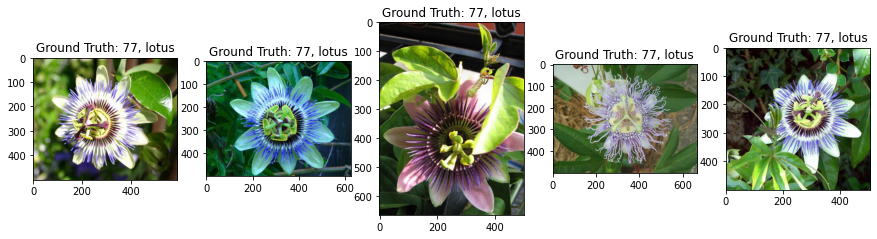

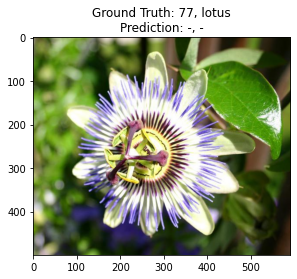

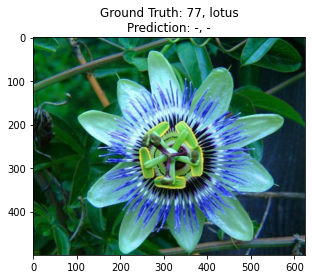

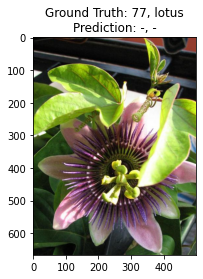

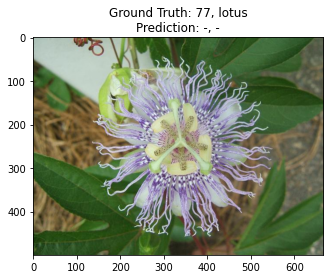

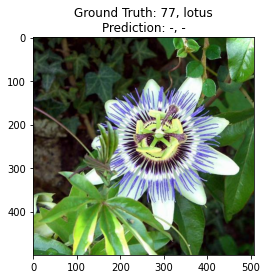

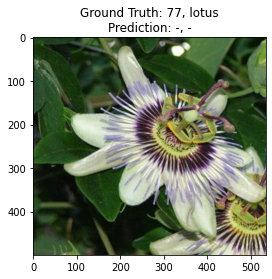

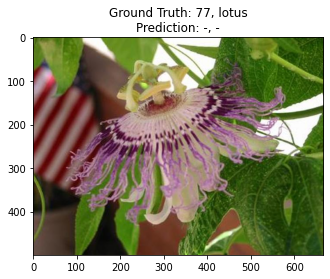

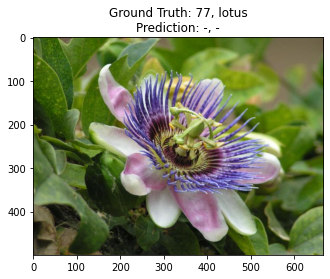

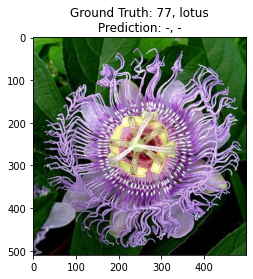

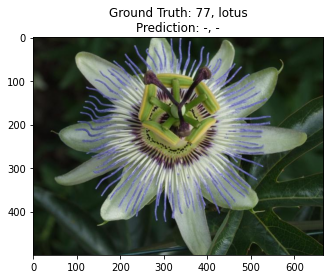

In [5]:
oxford102Dataset = Oxford102Dataset(csv_file='../dataset/imagelabels.csv',
                                    dataset_dir='../dataset/')

batch_visualization(oxford102Dataset, (1, 5), (15, 4))
    
